In [1]:
import tensorflow as tf
import os
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.per_process_gpu_memory_fraction = 0.1

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import csv
import h5py
import random
import keras

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers.core import Dense, Lambda, Flatten, Reshape, Dropout
from keras.layers.convolutional import Conv2D, UpSampling2D,Cropping2D,ZeroPadding2D,Conv1D, UpSampling1D,Cropping1D,ZeroPadding1D
from keras.layers.pooling import MaxPooling2D,  MaxPooling1D
from keras.layers.merge import Concatenate, Add
from keras.layers import Input
from keras.models import Sequential
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate
from keras.models import load_model

from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix

In [ ]:
#coping the training data to numpy variables
data_v = np.load("S_Train/S_Training_video_10sec_norm.npz")
video = data_v['video_10sec']
data_g = np.load("S_Train/S_Training_gaze_10sec.npz")
gaze = data_g['gaze_10sec']
data_l = np.load("S_Train/S_Training_label_10sec.npz")
label = data_l['label_10sec']

#coping the Testing data to numpy variables
data_vv = np.load("S_Val/S_Validation_video_10sec_norm.npz")
video_v = data_vv['video_10sec']
data_vg = np.load("S_Val/S_Validation_gaze_10sec.npz")
gaze_v = data_vg['gaze_10sec']
data_vl = np.load("S_Val/S_Validation_label_10sec.npz")
label_v = data_vl['label_10sec']

#coping the Validation data to numpy variables
data_tv = np.load("S_Test/S_Testing_video_10sec_norm.npz")
video_t = data_tv['video_10sec']
data_tg = np.load("S_Test/S_Testing_gaze_10sec.npz")
gaze_t = data_tg['gaze_10sec']
data_tl = np.load("S_Test/S_Testing_label_10sec.npz")
label_t = data_tl['label_10sec']



In [ ]:
#getting the shape paramaeters
(n_v,r_v,c_v,ch_v) = video.shape

In [ ]:
#setting the input shape
input_shape1 = (r_v, c_v, ch_v)
input_shape2 = (30,2,1)

In [ ]:
#taking only gaze x and gaze y and taking only the label encoding for training set
gaze_q = gaze[:,:,(1,2)]
label_q = label[:,(1,2,3,4,5,6,7,8,9)]
#reshaping the gaze input suitable for CNN(Training)
(l,m,n) = gaze_q.shape
gaze_q = np.reshape(gaze_q,(l,m,n,1))

In [ ]:
#taking only gaze x and gaze y and taking only the label encoding for testing set
gaze_qv = gaze_v[:,:,(1,2)]
label_qv = label_v[:,(1,2,3,4,5,6,7,8,9)]
#reshaping the gaze input suitable for CNN(Testing)
(lv,mv,nv) = gaze_qv.shape
gaze_qv = np.reshape(gaze_qv,(lv,mv,nv,1))

In [ ]:
#taking only gaze x and gaze y and taking only the label encoding for validation set
gaze_qt = gaze_t[:,:,(1,2)]
label_qt = label_t[:,(1,2,3,4,5,6,7,8,9)]
#reshaping the gaze input suitable for CNN(Validation)
(lt,mt,nt) = gaze_qt.shape
gaze_qt = np.reshape(gaze_qt,(lt,mt,nt,1))

In [3]:
#definition of the loss function
def multitask_loss(y_true, y_pred):
            # Avoid divide by 0
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            # Multi-task loss
            return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))

In [40]:
# Model for Scene Input
scene_input_layer = Input(shape=input_shape1)
convolution_layer11 = Conv2D(7, kernel_size=5, activation='relu')(scene_input_layer)
convolution_layer11 = Dropout(0.4)(convolution_layer11)
convolution_layer12 = Conv2D(4, kernel_size=3,padding = 'same', activation='relu')(convolution_layer11)
pooling_layer12 = MaxPooling2D(pool_size=(3, 3))(convolution_layer12)
flattened_layer1 = Flatten()(pooling_layer12)

# Model for Gaze Input
gaze_input_layer = Input(shape=input_shape2)
convolution_layer21 = Conv2D(8, kernel_size=2, activation='relu')(gaze_input_layer)
convolution_layer21 = Dropout(0.4)(convolution_layer21)
pooling_layer21 = MaxPooling2D(pool_size=(3, 3),padding= 'same')(convolution_layer21)
flattened_layer2 = Flatten()(pooling_layer21)


concatenated_layer = concatenate([flattened_layer1, flattened_layer2])

# Third model
concatenated_layer = Reshape((-1,1))(concatenated_layer)
convolution_layer31 = Conv1D(3, kernel_size=12, activation='relu')(concatenated_layer)
convolution_layer31 = Dropout(0.4)(convolution_layer31)
pooling_layer31 = MaxPooling1D(pool_size=20,)(convolution_layer31)
flattened_layer3 = Flatten()(pooling_layer31)
output_layer = Dense(9, activation='sigmoid')(flattened_layer3)
model = Model(inputs=[scene_input_layer, gaze_input_layer], outputs=output_layer)

# Model Summary
print(model.summary())


model.compile(optimizer='Adam', loss=multitask_loss, metrics = [multitask_loss,'accuracy'])



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 90, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 86, 156, 7)   532         input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 30, 2, 1)     0                                            
__________________________________________________________________________________________________
dropout_16 (Dropout)            (None, 86, 156, 7)   0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

In [41]:
#training
%%time
history = model.fit([video, gaze_q], label_q,
          batch_size=1500,
          epochs=100,
          verbose=1, shuffle = True, validation_data = ([video_t, gaze_qt], label_qt))

Train on 22717 samples, validate on 6765 samples
Epoch 1/100
22717/22717 [==============================] - 16s 716us/step - loss: 4.8332 - multitask_loss: 4.8332 - acc: 0.1026 - val_loss: 5.0460 - val_multitask_loss: 5.0460 - val_acc: 0.0820
Epoch 2/100
22717/22717 [==============================] - 15s 676us/step - loss: 4.3825 - multitask_loss: 4.3825 - acc: 0.1799 - val_loss: 4.9616 - val_multitask_loss: 4.9616 - val_acc: 0.1252
Epoch 3/100
22717/22717 [==============================] - 15s 680us/step - loss: 4.3203 - multitask_loss: 4.3203 - acc: 0.1819 - val_loss: 4.9688 - val_multitask_loss: 4.9688 - val_acc: 0.0816
Epoch 4/100
22717/22717 [==============================] - 16s 685us/step - loss: 4.2909 - multitask_loss: 4.2909 - acc: 0.1989 - val_loss: 4.9587 - val_multitask_loss: 4.9587 - val_acc: 0.1008
Epoch 5/100
22717/22717 [==============================] - 16s 683us/step - loss: 4.2753 - multitask_loss: 4.2753 - acc: 0.1930 - val_loss: 4.9923 - val_multitask_loss: 4.9923

Epoch 43/100
22717/22717 [==============================] - 16s 694us/step - loss: 3.2374 - multitask_loss: 3.2374 - acc: 0.3776 - val_loss: 4.5205 - val_multitask_loss: 4.5205 - val_acc: 0.1777
Epoch 44/100
22717/22717 [==============================] - 16s 686us/step - loss: 3.2389 - multitask_loss: 3.2389 - acc: 0.3828 - val_loss: 4.4534 - val_multitask_loss: 4.4534 - val_acc: 0.1811
Epoch 45/100
22717/22717 [==============================] - 16s 687us/step - loss: 3.2270 - multitask_loss: 3.2270 - acc: 0.3795 - val_loss: 4.4947 - val_multitask_loss: 4.4947 - val_acc: 0.1752
Epoch 46/100
22717/22717 [==============================] - 16s 689us/step - loss: 3.2114 - multitask_loss: 3.2114 - acc: 0.3842 - val_loss: 4.5152 - val_multitask_loss: 4.5152 - val_acc: 0.1775
Epoch 47/100
22717/22717 [==============================] - 16s 686us/step - loss: 3.2028 - multitask_loss: 3.2028 - acc: 0.3857 - val_loss: 4.4831 - val_multitask_loss: 4.4831 - val_acc: 0.1595
Epoch 48/100
22717/22717 

22717/22717 [==============================] - 16s 690us/step - loss: 2.9763 - multitask_loss: 2.9763 - acc: 0.4115 - val_loss: 4.3908 - val_multitask_loss: 4.3908 - val_acc: 0.1877
Epoch 86/100
22717/22717 [==============================] - 16s 687us/step - loss: 2.9695 - multitask_loss: 2.9695 - acc: 0.4148 - val_loss: 4.4447 - val_multitask_loss: 4.4447 - val_acc: 0.1703
Epoch 87/100
22717/22717 [==============================] - 16s 684us/step - loss: 2.9537 - multitask_loss: 2.9537 - acc: 0.4157 - val_loss: 4.3889 - val_multitask_loss: 4.3889 - val_acc: 0.1883
Epoch 88/100
22717/22717 [==============================] - 16s 690us/step - loss: 2.9448 - multitask_loss: 2.9448 - acc: 0.4145 - val_loss: 4.3867 - val_multitask_loss: 4.3867 - val_acc: 0.1894
Epoch 89/100
22717/22717 [==============================] - 16s 686us/step - loss: 2.9408 - multitask_loss: 2.9408 - acc: 0.4148 - val_loss: 4.4212 - val_multitask_loss: 4.4212 - val_acc: 0.1661
Epoch 90/100
22717/22717 [============

dict_keys(['val_loss', 'val_multitask_loss', 'val_acc', 'loss', 'multitask_loss', 'acc'])


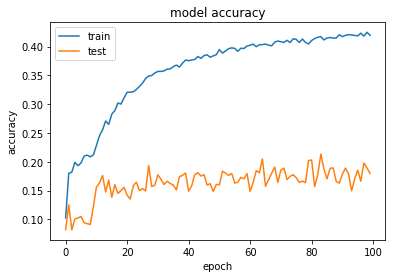

In [42]:
#plotting accuracy graph
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy Graph')
plt.ylabel('Accuracy Value')
plt.xlabel('Number of Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

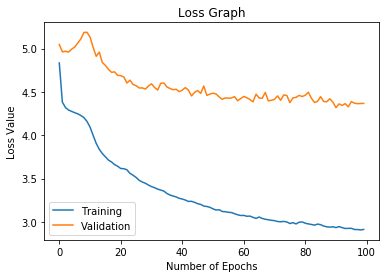

In [43]:
# plotting loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Graph')
plt.ylabel('Loss Value')
plt.xlabel('Number of Epochs')
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()

In [44]:
model.save("CNN_model_1d_ml3_simple_taken.h5")

In [45]:
model.evaluate([video_v, gaze_qv], label_qv)

2974/2974 [==============================] - 1s 393us/step


[4.732328230371071, 4.732328230371071, 0.19233355754842354]

In [ ]:
# Prediction
result = model.predict([video_v, gaze_qv])
# rounding of the results 
result[result>=0.5] =1
result[result<0.5] =0

In [48]:
#Calculating the Hamming loss
print(hamming_loss(label_qv,result))

0.24153777180004482


In [50]:
# Calculating the confusion matrices
print("Activity 1")
print(confusion_matrix(label_qv[:,0], result[:,0]))
print("Activity 2")
print(confusion_matrix(label_qv[:,1], result[:,1]))
print("Activity 3")
print(confusion_matrix(label_qv[:,2], result[:,2]))
print("Activity 4")
print(confusion_matrix(label_qv[:,3], result[:,3]))
print("Activity 5")
print(confusion_matrix(label_qv[:,4], result[:,4]))
print("Activity 6")
print(confusion_matrix(label_qv[:,5], result[:,5]))
print("Activity 7")
print(confusion_matrix(label_qv[:,6], result[:,6]))
print("Activity 8")
print(confusion_matrix(label_qv[:,7], result[:,7]))
print("Activity 9")
print(confusion_matrix(label_qv[:,8], result[:,8]))

53
Activity 1
[[2388   58]
 [ 499   29]]
Activity 2
[[2081   65]
 [ 813   15]]
Activity 3
[[2175  106]
 [ 664   29]]
Activity 4
[[2363  102]
 [ 465   44]]
Activity 5
[[2013  117]
 [ 796   48]]
Activity 6
[[1953   82]
 [ 894   45]]
Activity 7
[[2675   28]
 [ 253   18]]
Activity 8
[[2582    8]
 [ 374   10]]
Activity 9
[[1507  150]
 [ 991  326]]


In [51]:
# Calculating the confusion matrices in percentage
print("Activity 1")
a = confusion_matrix(label_qv[:,0], result[:,0])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 2")
a = confusion_matrix(label_qv[:,1], result[:,1])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 3")
a = confusion_matrix(label_qv[:,2], result[:,2])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 4")
a = confusion_matrix(label_qv[:,3], result[:,3])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 5")
a = confusion_matrix(label_qv[:,4], result[:,4])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 6")
a = confusion_matrix(label_qv[:,5], result[:,5])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 7")
a = confusion_matrix(label_qv[:,6], result[:,6])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 8")
a = confusion_matrix(label_qv[:,7], result[:,7])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)
print("Activity 9")
a = confusion_matrix(label_qv[:,8], result[:,8])
an = np.asarray(a)
s = np.sum(an)
print((an/s)*100)

Activity 1
[[80.29589778  1.95023537]
 [16.77874916  0.97511769]]
Activity 2
[[69.9731002   2.18560861]
 [27.33691997  0.50437122]]
Activity 3
[[73.1338265   3.56422327]
 [22.32683255  0.97511769]]
Activity 4
[[79.45527909  3.42972428]
 [15.63550773  1.4794889 ]]
Activity 5
[[67.68661735  3.93409549]
 [26.76529926  1.6139879 ]]
Activity 6
[[65.66913248  2.75722932]
 [30.06052455  1.51311365]]
Activity 7
[[89.9462004   0.94149294]
 [ 8.5070612   0.60524546]]
Activity 8
[[86.81909886  0.26899798]
 [12.57565568  0.33624748]]
Activity 9
[[50.67249496  5.04371217]
 [33.32212508 10.96166779]]
